In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
np.random.seed(1234)
data = datasets.load_diabetes(as_frame=True)

df = pd.DataFrame(data=data.data)
y = data.target

X = df.head().to_numpy()
y=y.head().to_numpy()

X = (X-X.mean())/X.std()
y = (y-y.mean())/y.std()



In [5]:
type(df) == pd.core.frame.DataFrame

True

In [6]:
df.to_numpy().shape

(442, 10)

In [7]:
def MSE(beta):
    return np.sum((y-X@beta)**2)

In [8]:
class IncrementalLinearGradientBooster:
    def __init__(self, n_steps: int= 500, gamma: float=1, loss: str='L2', eps: float= 10**(-10)) -> None:
        self.supported_loss = { 
            'L2': self._loss_L2,
            'L1': self._loss_L1
            }
        
        assert gamma <= 1
        assert loss in self.supported_loss.keys()

        self.n_steps = n_steps
        self.gamma = gamma
        self.loss = self.supported_loss[loss]
        self.is_fitted = False

        self.eps = eps

    def _loss_L2(self, y, yhat):
        return np.sum((y-yhat)**2)
    
    def _loss_L1(self, y, yhat):
        return np.sum(np.abs((y-yhat)))
    
    def _recast_input(self, X):
        if type(X) == np.ndarray:
            return X
        elif type(X) == pd.core.frame.DataFrame:
            return X.to_numpy()
        else:
            raise TypeError('Only pandas data frames or numpy ndarrays are supported')


    def fit(self, X, y, Xtest= None, ytest=None):
        """
        X: features
        y: target

        At this stage, we assume that X and y are both preprocessed and scaled.
        We therefore do not model intercept.
        """
        self.X = self._recast_input(X).copy()   # original X, as an array
        self.y = self._recast_input(y).copy()   # original y, as an array
        self.working_y = self.y.copy()          # the residuals for weak lerner i
        self.actual_steps = -1
        n_train = self.X.shape[0]


        # array which stores the coefficients found
        self.coeff = np.zeros(self.X.shape[1])

        self.mse = []
        self.mse.append(self.loss(self.y, self._predict(self.X))/n_train)

        testset = False
        if Xtest is not None and ytest is not None:
            self.Xtest = Xtest
            self.ytest = ytest
            testset = True
            n_test = self.Xtest.shape[0]
            self.msetest = []

        for i in range(self.n_steps):
            best_coeff = 0 # value of best coeff to add to model
            best_coeff_index = -1 # index of the best model found on this iteration
            best_coeff_score_inv = 0 # 1/MSE s.t. 0 is infinitely bad.
            if i%(self.n_steps//10) == 0:
                print(f'{i/self.n_steps*100: .2f} %')


            for j in range(len(self.coeff)):
                x = self.X[:,j]

                beta = np.sum(x*self.working_y,)/np.sum(x*x)
                residuals = self.loss(self.working_y, x*beta)

                if 1/residuals > best_coeff_score_inv:
                    best_coeff_index = j
                    best_coeff = beta
                    best_coeff_score_inv = 1/residuals
                

            if abs(self.mse[i] - residuals)*self.n_steps < self.eps:
                self.actual_steps = i
                #break

            best_coeff_scaled = best_coeff * self.gamma#*( 1- residuals/self.mse[0])
            self.coeff[best_coeff_index] += best_coeff_scaled
            self.mse.append(self.loss(self._predict(self.X), self.y)/n_train)
            self.working_y = self.y - self._predict(self.X)

            if testset:
                self.msetest.append(self.loss(self._predict(self.Xtest), self.ytest)/n_test)



        self.is_fitted = True
    
        print('Done fitting', self.coeff)


    def _predict(self, X):
        return X@self.coeff
    
    def predict(self, X):
        if not self.is_fitted:
            raise RuntimeError('Fit before predicting')

        return self._predict(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        u = ((y - y_pred)** 2).sum()
        v = ((y - y.mean()) ** 2).sum()
        return 1 - u/v



In [9]:
n = 1000
model = IncrementalLinearGradientBooster(n_steps=n, gamma=0.01)
model.fit(X,y)

 0.00 %
 10.00 %
 20.00 %
 30.00 %
 40.00 %
 50.00 %
 60.00 %
 70.00 %
 80.00 %
 90.00 %
Done fitting [-0.07057795  0.          0.          0.          0.          0.
  0.          1.10074184  0.23097421  0.16501463]


In [10]:
print(model.coeff)
print(MSE(model.coeff))

[-0.07057795  0.          0.          0.          0.          0.
  0.          1.10074184  0.23097421  0.16501463]
0.00017955356430606793


In [11]:
MSE(np.zeros_like(model.coeff))

5.000000000000001

In [12]:
beta_OLS = np.linalg.inv(X.T@X)@X.T@y
MSE(beta_OLS)

2.4468239606723294

In [13]:
beta_OLS

array([-0.12340747,  0.78655368, -3.42403321,  0.544043  , -4.41733867,
        1.74313834, -0.66998439,  1.07858861,  1.61529613, -0.57403381])

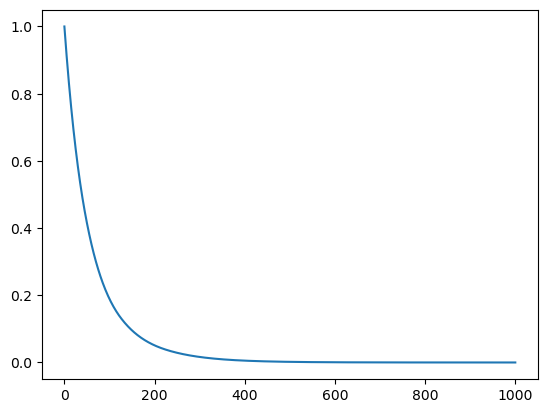

In [14]:
plt.plot(range(len(model.mse)), model.mse)

In [15]:
model.coeff

array([-0.07057795,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.10074184,  0.23097421,  0.16501463])

In [16]:
from sklearn.linear_model import LinearRegression


In [17]:
LinearRegression().fit(X, y).predict(X)

array([ 0.22515115, -1.59521988, -0.01437135,  1.54252493, -0.15808485])

In [18]:
model.predict(X)

array([ 0.21709661, -1.59271966, -0.00468378,  1.54208152, -0.15429259])

In [19]:
x = np.array([[1,2,3], [1.5, 2.5, 3.5]])

df = pd.DataFrame(x)

In [20]:
len(df.columns)

3

In [21]:
def expand(df, n=2):
    p = len(df.columns)
    dfs = [df]

    for power in range(1, n):
        tmp = pd.DataFrame()
        for colname in df.columns:
            
            for df2 in dfs:
                for colname2 in df2.columns:
                    tmp[str(colname) + '_'+ str(colname2)] = df[colname] * df2[colname2]
        dfs.append(tmp)
    
    return pd.concat(dfs, axis=1)



expand(df,n=4)

,0,1,2,0_0,0_1,0_2,1_0,1_1,1_2,2_0,...,2_1_2_2,2_2_0_0,2_2_0_1,2_2_0_2,2_2_1_0,2_2_1_1,2_2_1_2,2_2_2_0,2_2_2_1,2_2_2_2
0,1.0,2.0,3.0,1.00,2.00,3.00,2.00,4.00,6.00,3.00,...,54.0000,9.0000,18.0000,27.0000,18.0000,36.0000,54.0000,27.0000,54.0000,81.0000
1,1.5,2.5,3.5,2.25,3.75,5.25,3.75,6.25,8.75,5.25,...,107.1875,27.5625,45.9375,64.3125,45.9375,76.5625,107.1875,64.3125,107.1875,150.0625


In [22]:
from sklearn.model_selection import train_test_split

In [23]:
df = pd.DataFrame(data=data.data)
y = data.target

X = df
y=y

X = (X-X.mean())/X.std()
y = (y-y.mean())/y.std()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

pow=3
Xtrain_expanded = expand(Xtrain, n=pow)
Xtest_expanded = expand(Xtest, n=pow)

In [24]:
print(len(Xtrain_expanded.columns))
print(len(Xtrain_expanded.index))

1210
331


In [25]:
n = 10000
model = IncrementalLinearGradientBooster(n_steps=n, gamma=0.001)
model.fit(Xtrain_expanded.to_numpy(),ytrain.to_numpy(), Xtest=Xtest_expanded.to_numpy(), ytest=ytest.to_numpy())
# model.fit(Xtrain_expanded.to_numpy(),ytrain.to_numpy())

 0.00 %
 10.00 %
 20.00 %
 30.00 %
 40.00 %
 50.00 %
 60.00 %
 70.00 %
 80.00 %
 90.00 %
Done fitting [0. 0. 0. ... 0. 0. 0.]


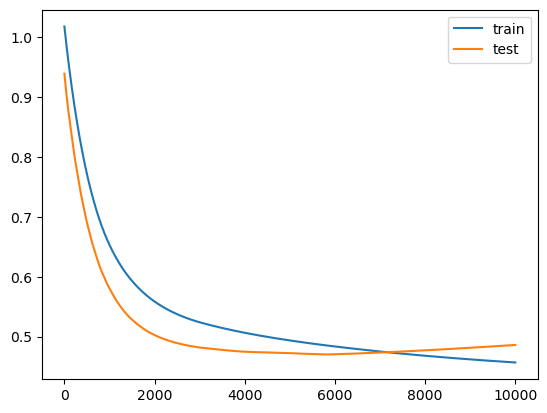

In [26]:
plt.plot(range(len(model.mse)), model.mse, label='train')
plt.plot(range(len(model.msetest)), model.msetest, label='test')
plt.legend()

In [27]:
for i, beta in enumerate(model.coeff):
    if beta != 0:
        print(Xtrain_expanded.columns[i], beta)

s3 -0.06665201849020944
s5 0.2973313054250312
age_sex 0.05857862649775486
sex_s5 -0.02828904832690737
bmi_bp 0.02530790935267289
s4_s6 0.0180642883491198
age_age_sex -0.00029302919069366267
age_bmi_s3 -0.0037736899115804563
sex_sex_sex -0.08412590410693052
sex_sex_bmi 0.2750378901957555
sex_sex_bp 0.09199328069605105
sex_sex_s6 0.020123088777134642
sex_bp_s3 -0.027056797313974562
bmi_age_s3 -0.00016609002437692363
bmi_sex_sex 0.039345266035189244
bmi_bmi_s1 -0.03175219664222628
bmi_bmi_s3 -0.02025932888220191
bp_sex_sex 0.005141914687834454
bp_sex_s3 -0.0009658713702017166
bp_bp_bp 0.020509131263979272
s1_bmi_bmi -0.000726795573500928
s2_s5_s6 0.0174091089295443
s3_age_bmi -5.453652822900777e-05
s3_bmi_bmi -0.0003672248365741548
s3_s6_s6 -0.024050559578443348
s5_s2_s6 4.989573700272805e-05
s6_sex_sex 0.00015829026021780293
s6_s2_s5 0.0003732218727604186
s6_s3_s6 -0.00032259710428175184


In [28]:
yhat = model.predict(Xtrain_expanded)

In [29]:
results = pd.DataFrame()
results['y'] = y
results['inc'] = yhat
results['ols'] = LinearRegression().fit(X, y).predict(X)

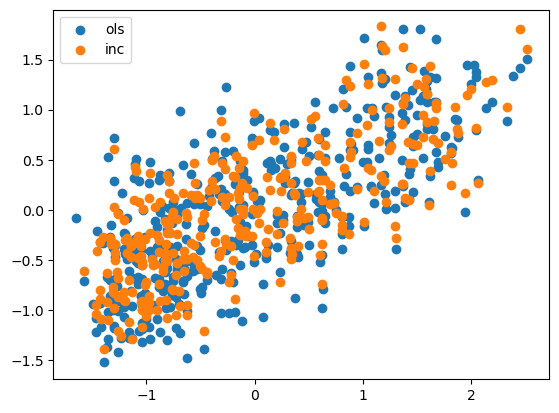

In [30]:
plt.scatter(results['y'], results['ols'], label='ols')
plt.scatter(results['y'], results['inc'], label='inc')
# plt.plot([-2, 2], [-2,2])
plt.legend()

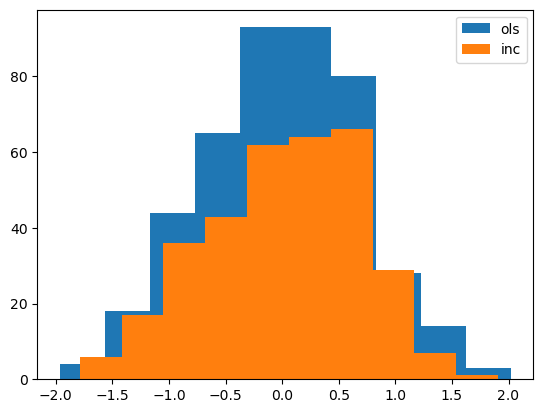

In [31]:
plt.hist( results['ols'] - results['y'], label='ols')
plt.hist( results['inc']  - results['y'], label='inc')
# plt.plot([-2, 2], [-2,2])
plt.legend()

In [32]:
print((results['y'] - results['inc']).mean())
print((results['y'] - results['ols']).mean())

-0.028634411871650934
4.018906876471155e-18


In [33]:
print(np.sum((yhat - y)**2))
print(np.sum((LinearRegression().fit(X, y).predict(X) - y)**2))

151.2448109475666
212.67294580082574


In [34]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0, n_estimators= 1000)
reg.fit(Xtrain_expanded, ytrain)


GradientBoostingRegressor(n_estimators=1000, random_state=0)

In [35]:
def MSE(model, X, y):
    return np.mean((model.predict(X) - y)**2)

In [36]:
print(np.mean((model.predict(Xtest_expanded) - ytest))**2)
print(np.mean((reg.predict(Xtest_expanded) - ytest)**2))

0.002272892115600008
0.6570488463883459


In [37]:
print(LinearRegression().fit(Xtrain, ytrain).score(Xtest, ytest))
print(reg.score(Xtest_expanded, ytest))
print(model.score(Xtest_expanded, ytest))

0.46937607855967356
0.3000722470926488
0.4821229276886134


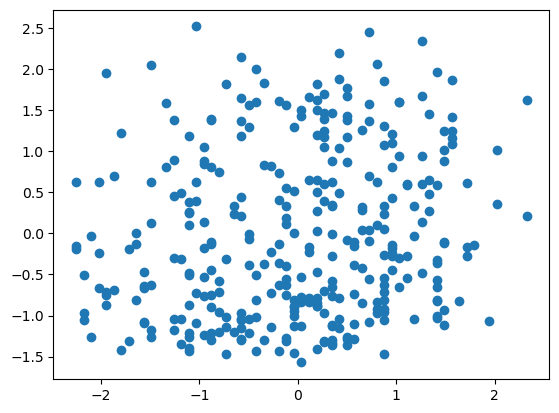

In [38]:
plt.scatter(Xtrain['age'], ytrain)

In [39]:
import seaborn as sns

In [40]:
ytrain.head()

67    -0.715155
97     1.645629
270    0.646836
133   -0.896754
129    1.502945
Name: target, dtype: float64

/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


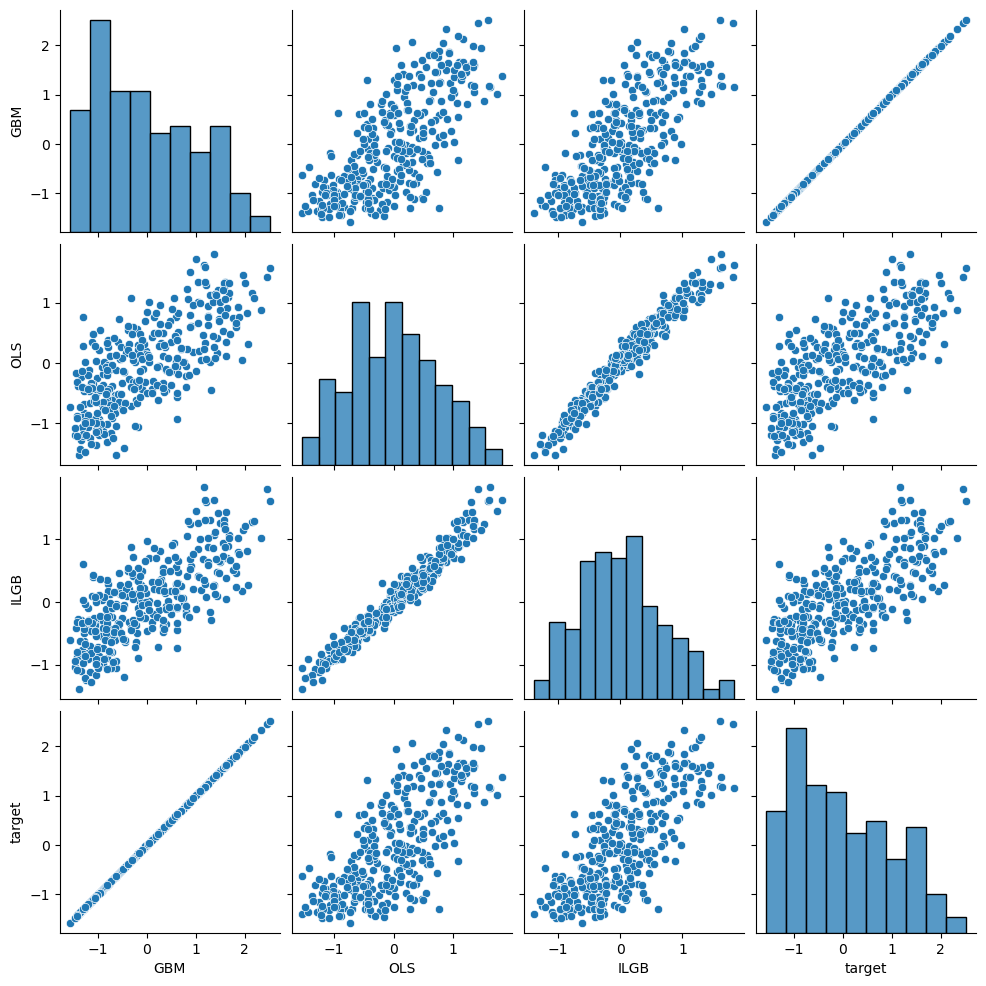

In [41]:
def pairplot(X, X_expanded, y):
    to_plot = pd.DataFrame()
    y = y.to_numpy()
    X = X.to_numpy()
    X_expanded = X_expanded.to_numpy()
    to_plot['GBM'] = reg.predict(X_expanded)
    to_plot['OLS'] = LinearRegression().fit(X, y).predict(X)
    to_plot['ILGB'] = model.predict(X_expanded)
    to_plot['target'] = y

    return sns.pairplot(to_plot)

pairplot(Xtrain, Xtrain_expanded, ytrain)

/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


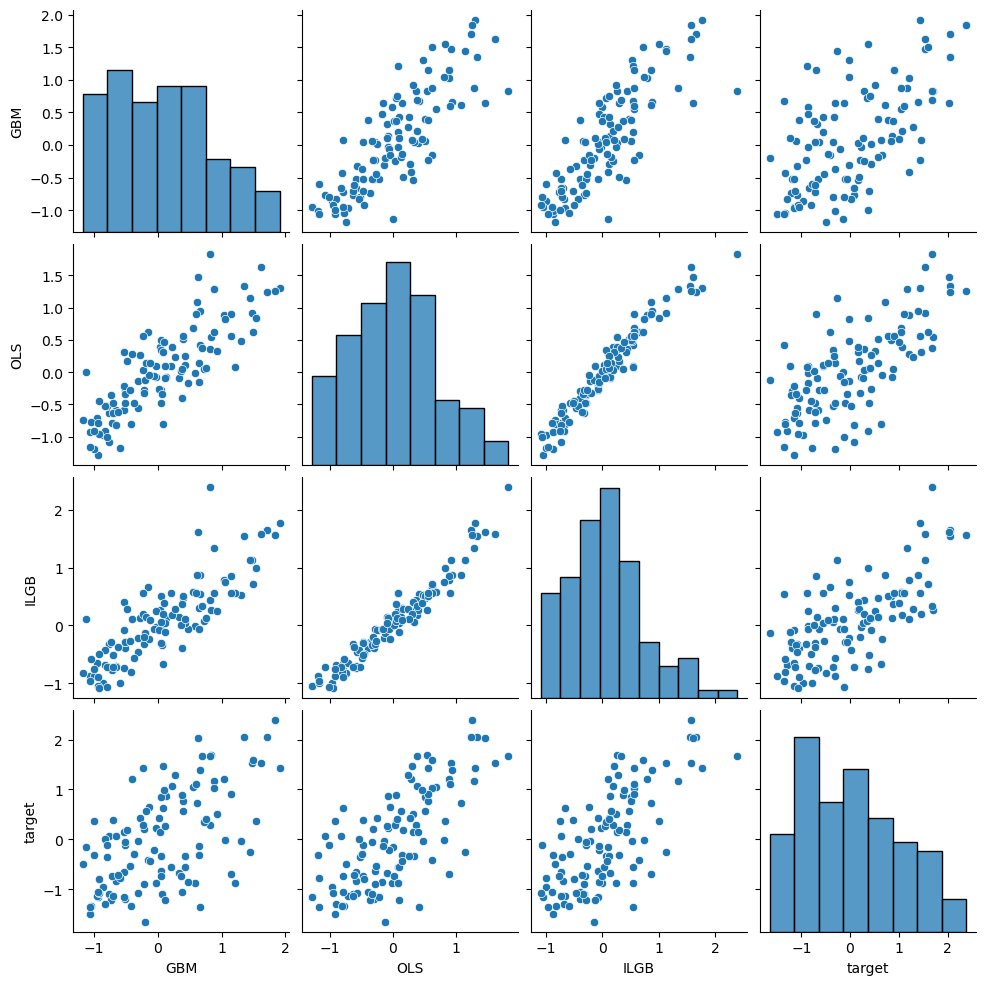

In [42]:
pairplot(Xtest, Xtest_expanded, ytest)